In [1]:
from model import atp_graph, losses
from data import synthetic_data_gen, feature_extractor
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from model import atp_pipeline
from comparison_models.tnp import tnp_pipeline
from data import dataset_preparer
import argparse
from Tutorials.helper import batcher
import os

2023-05-03 17:39:17.163607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [61]:
dataset = "weather"
model = "atp"
iterations = 300
num_repeats = 1
n_C = 100
n_T = 50

In [62]:


if dataset == "weather":
    x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.weather_processor(path_to_weather_data="datasets/weather.csv") 
    save_dir = "weights/forecasting/weather"


batch_size = 32
test_batch_s = 100

nll_list = []
mse_list = []

for i in range(num_repeats):

    step = 1
    run= 50 + i
    tf.random.set_seed(run)

    if model == "atp":
        model = atp_pipeline.instantiate_atp(dataset)

    if model == "tnp":
        model = tnp_pipeline.instantiate_tnp(dataset)

    tr_step = atp_graph.build_graph()

    ###### can we put the name of the model into the folder name #########?

    name_comp = 'run_' + str(run)
    folder = save_dir + '/ckpt/check_' + name_comp
    if not os.path.exists(folder): os.mkdir(folder)
    opt = tf.keras.optimizers.Adam(3e-4)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
    ckpt.restore(manager.latest_checkpoint) 
    sum_mse_tot = 0; sum_nll_tot = 0
    mini = 50000


   



In [63]:
import matplotlib.pyplot as plt

In [64]:
array = []
train_array = []

2023-05-03 17:49:06.529873: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: atp_pipeline_2/cond/branch_executed/_11


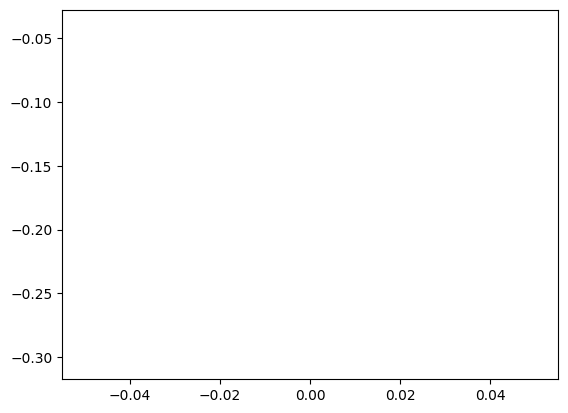

tf.Tensor(-0.30417353, shape=(), dtype=float32)
tf.Tensor(-0.30417353, shape=(), dtype=float32)


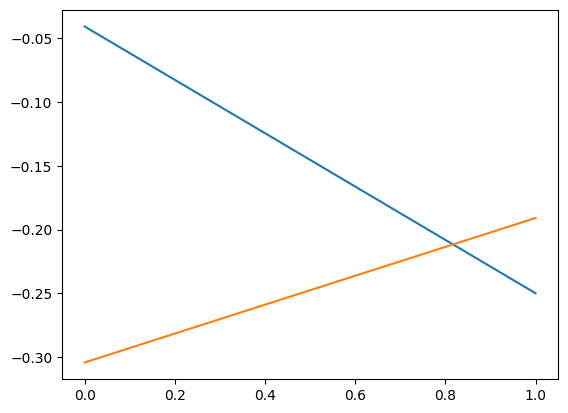

tf.Tensor(-0.19094354, shape=(), dtype=float32)
tf.Tensor(-0.30417353, shape=(), dtype=float32)


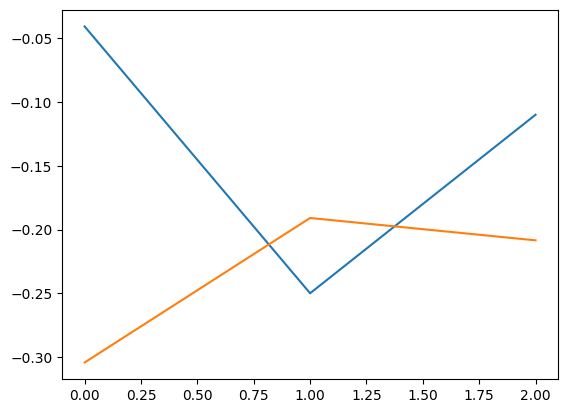

tf.Tensor(-0.20846325, shape=(), dtype=float32)
tf.Tensor(-0.30417353, shape=(), dtype=float32)


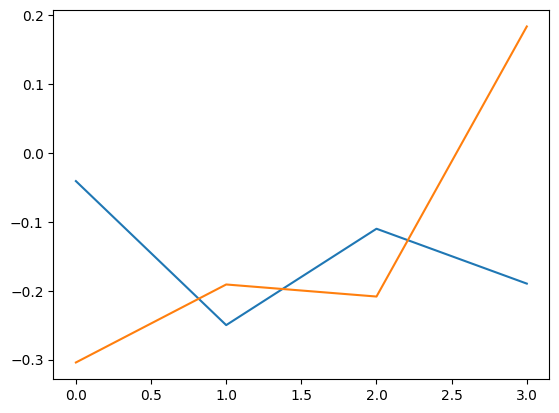

tf.Tensor(0.1835769, shape=(), dtype=float32)
tf.Tensor(-0.30417353, shape=(), dtype=float32)


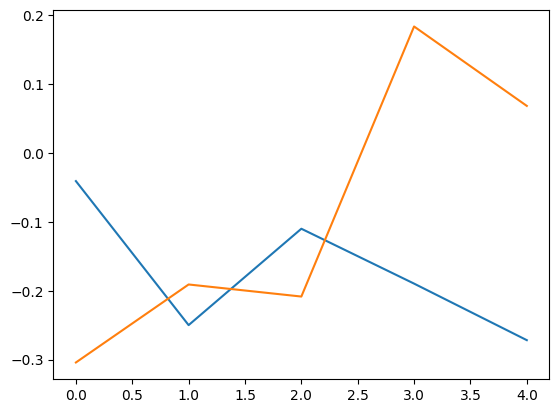

tf.Tensor(0.068292044, shape=(), dtype=float32)
tf.Tensor(-0.30417353, shape=(), dtype=float32)


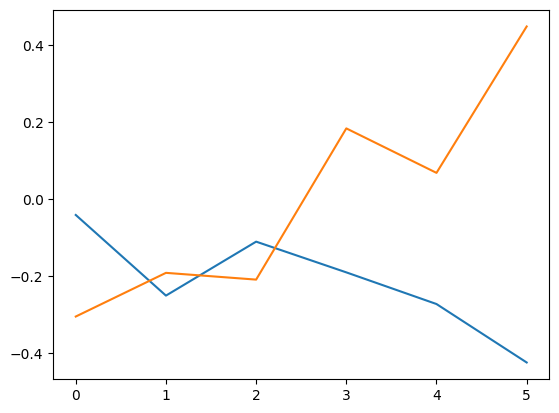

tf.Tensor(0.44781002, shape=(), dtype=float32)
tf.Tensor(-0.30417353, shape=(), dtype=float32)


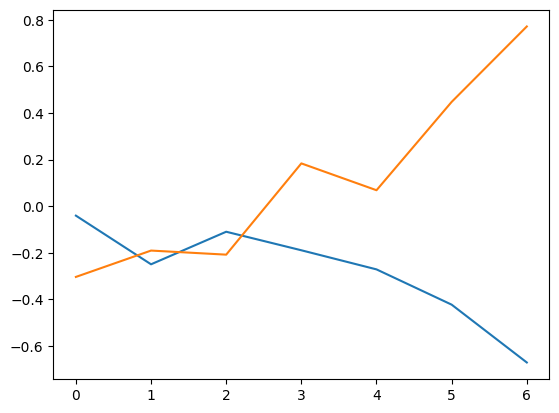

tf.Tensor(0.7718156, shape=(), dtype=float32)
tf.Tensor(-0.30417353, shape=(), dtype=float32)


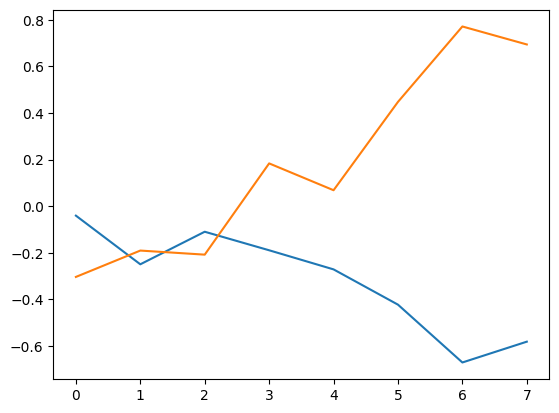

tf.Tensor(0.69455665, shape=(), dtype=float32)
tf.Tensor(-0.30417353, shape=(), dtype=float32)



KeyboardInterrupt



In [65]:
for i in range(5000):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not just forecasting
    _,_, nll_pp_tr, _ = tr_step(model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        train_array.append(nll_pp_tr)
        idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
        t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
        μ, log_σ = model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        array.append(nll_pp_te)
        
        plt.plot(train_array)
        plt.plot(array)
        plt.show()

        print(nll_pp_te)
        print(min(array))

        if nll_pp_te < mini:
            mini = nll_pp_te
            manager.save()
            step += 1
            ckpt.step.assign_add(1)




In [17]:
ckpt = tf.train.Checkpoint(step=tf.Variable(step), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

In [22]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))

t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)


In [23]:
nll_pp_te

<tf.Tensor: shape=(), dtype=float32, numpy=-0.31990704>

In [18]:
test_batch_s = 100

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = x_test.shape[0]//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)    
    print(len(idx_list))
    print(test_batch_s)
    t_te,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)


nll_list.append(nllx.numpy())
mse_list.append(msex.numpy())

#     np.save(save_dir + '/nll_list.npy', nll_list)    
#     np.save(save_dir + '/mse_list.npy', mse_list)  

10480
100
10380
100
10280
100
10180
100
10080
100
9980
100
9880
100
9780
100
9680
100
9580
100
9480
100
9380
100
9280
100
9180
100
9080
100
8980
100
8880
100
8780
100
8680
100
8580
100
8480
100
8380
100
8280
100
8180
100
8080
100
7980
100
7880
100
7780
100
7680
100
7580
100
7480
100
7380
100
7280
100
7180
100
7080
100
6980
100
6880
100
6780
100
6680
100
6580
100
6480
100
6380
100
6280
100
6180
100
6080
100
5980
100
5880
100
5780
100
5680
100
5580
100
5480
100
5380
100
5280
100
5180
100
5080
100
4980
100
4880
100
4780
100
4680
100
4580
100
4480
100
4380
100
4280
100
4180
100
4080
100
3980
100
3880
100
3780
100
3680
100
3580
100
3480
100
3380
100
3280
100
3180
100
3080
100
2980
100
2880
100
2780
100
2680
100
2580
100
2480
100
2380
100
2280
100
2180
100
2080
100
1980
100
1880
100
1780
100
1680
100
1580
100
1480
100
1380
100
1280
100
1180
100
1080
100
980
100
880
100
780
100
680
100
580
100
480
100
380
100
280
100
180
100
80
80


In [46]:
idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
t_te,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)

μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
print(sum_nll/n_T/100)

tf.Tensor(0.39901254, shape=(), dtype=float32)


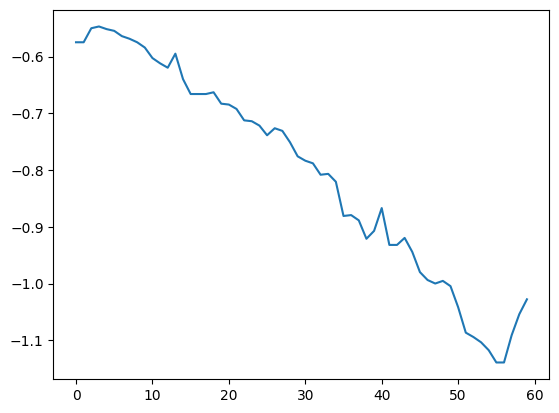

In [51]:
plt.plot(y_te[4])

In [52]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
print(sum_nll/n_T/100)

tf.Tensor(-0.3367923, shape=(), dtype=float32)


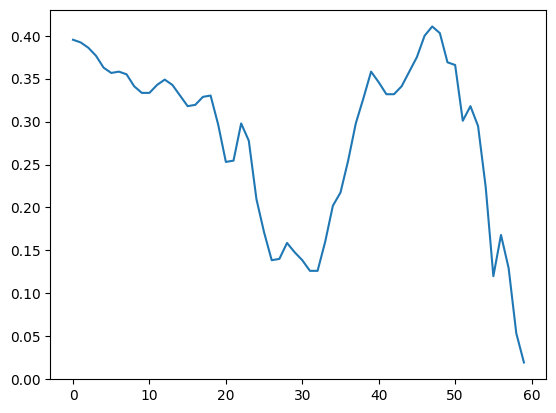

In [57]:
plt.plot(y_te[4])

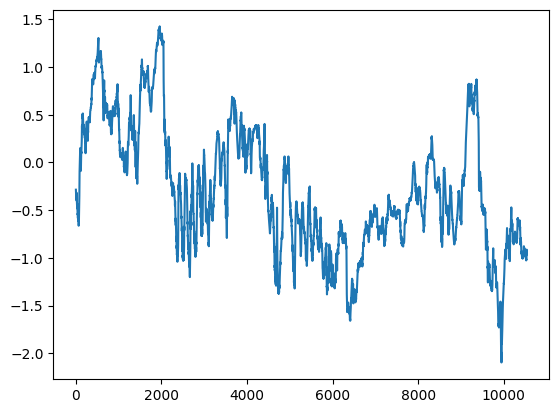

In [58]:
plt.plot(y_test[:,0,0])

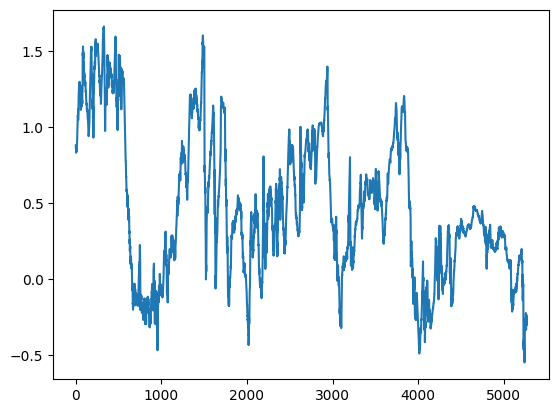

In [60]:
plt.plot(y_val[:,0,0])

In [29]:
sum_nll/n_T/100

<tf.Tensor: shape=(), dtype=float32, numpy=0.4331003>

In [19]:
nllx

<tf.Tensor: shape=(), dtype=float32, numpy=0.49623168>

In [20]:
msex

<tf.Tensor: shape=(), dtype=float32, numpy=0.10330206>